Using data [Only 4 moments]
Epoch 0: D (0.7490968108177185 real_err, 0.6336177587509155 fake_err) G (0.755440354347229 err); Real Dist ([3.9484433910101653, 1.2284454920670274]),  Fake Dist ([0.24088232949376107, 0.0323644885174625]) 


/home/lenovo/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:2016: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))


Epoch 100: D (0.5931983590126038 real_err, 0.6001887321472168 fake_err) G (0.7863580584526062 err); Real Dist ([3.9938577786684037, 1.2637233298612551]),  Fake Dist ([2.618754400730133, 0.010609699723107113]) 
Epoch 200: D (0.09719390422105789 real_err, 0.0855821892619133 fake_err) G (2.3968143463134766 err); Real Dist ([4.008558218002319, 1.1757513965077189]),  Fake Dist ([2.639625603199005, 0.15711760626053622]) 
Epoch 300: D (0.6912923455238342 real_err, 0.6717488169670105 fake_err) G (0.6876198649406433 err); Real Dist ([3.933358331859112, 1.26945794632914]),  Fake Dist ([2.4375218873023985, 2.3807680349121916]) 
Epoch 400: D (0.5653417110443115 real_err, 0.5355890393257141 fake_err) G (0.8795529007911682 err); Real Dist ([3.9578258094787597, 1.2492651479362125]),  Fake Dist ([4.979450378894806, 1.1132276342778082]) 
Epoch 500: D (0.5837213397026062 real_err, 0.511721670627594 fake_err) G (0.8411832451820374 err); Real Dist ([4.001049688503146, 1.2501995041518101]),  Fake Dist ([7.

Epoch 4100: D (0.6936395168304443 real_err, 0.6935544610023499 fake_err) G (0.6927390694618225 err); Real Dist ([4.015488250613212, 1.2243727644920053]),  Fake Dist ([6.03962288570404, 0.9538384339610768]) 
Epoch 4200: D (0.6935240626335144 real_err, 0.693510115146637 fake_err) G (0.6927778124809265 err); Real Dist ([4.010637751251459, 1.2143319778666448]),  Fake Dist ([6.036418906211853, 0.9563626056759795]) 
Epoch 4300: D (0.6934940218925476 real_err, 0.693498432636261 fake_err) G (0.692797839641571 err); Real Dist ([3.9788567459136246, 1.2578792304236095]),  Fake Dist ([6.107941230773926, 0.9792848858257838]) 
Epoch 4400: D (0.693483293056488 real_err, 0.693519651889801 fake_err) G (0.6927815079689026 err); Real Dist ([3.9724618227481843, 1.2342788706227792]),  Fake Dist ([6.130647192001343, 0.9416580341810611]) 
Epoch 4500: D (0.6933583617210388 real_err, 0.6934831738471985 fake_err) G (0.6928145289421082 err); Real Dist ([4.032872279405594, 1.198758559707202]),  Fake Dist ([6.0984

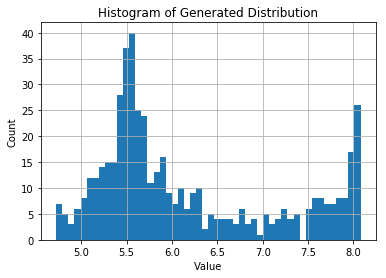

In [3]:
#!/usr/bin/env python

# Generative Adversarial Networks (GAN) example in PyTorch. Tested with PyTorch 0.4.1, Python 3.6.7 (Nov 2018)
# See related blog post at https://medium.com/@devnag/generative-adversarial-networks-gans-in-50-lines-of-code-pytorch-e81b79659e3f#.sch4xgsa9

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable

matplotlib_is_available = True
try:
  from matplotlib import pyplot as plt
except ImportError:
  print("Will skip plotting; matplotlib is not available.")
  matplotlib_is_available = False

# Data params
data_mean = 4
data_stddev = 1.25

# ### Uncomment only one of these to define what data is actually sent to the Discriminator
#(name, preprocess, d_input_func) = ("Raw data", lambda data: data, lambda x: x)
#(name, preprocess, d_input_func) = ("Data and variances", lambda data: decorate_with_diffs(data, 2.0), lambda x: x * 2)
#(name, preprocess, d_input_func) = ("Data and diffs", lambda data: decorate_with_diffs(data, 1.0), lambda x: x * 2)
(name, preprocess, d_input_func) = ("Only 4 moments", lambda data: get_moments(data), lambda x: 4)

print("Using data [%s]" % (name))

# ##### DATA: Target data and generator input data

def get_distribution_sampler(mu, sigma):#1xn data from a normal distribution
    return lambda n: torch.Tensor(np.random.normal(mu, sigma, (1, n)))  # Gaussian

def get_generator_input_sampler():
    return lambda m, n: torch.rand(m, n)  # Uniform-dist data into generator, _NOT_ Gaussian(returns data of size mxn)

# ##### MODELS: Generator model and discriminator model

class Generator(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, f):
        super(Generator, self).__init__()
        self.m1 = nn.Linear(input_size, hidden_size)
        self.map2 = nn.Linear(hidden_size, hidden_size)
        self.map3 = nn.Linear(hidden_size, output_size)
        self.f = f

    def forward(self, x):
        x = self.m1(x)
        x = self.f(x)
        x = self.map2(x)
        x = self.f(x)
        x = self.map3(x)
        return x

class Discriminator(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, f):
        super(Discriminator, self).__init__()
        self.map1 = nn.Linear(input_size, hidden_size)
        self.map2 = nn.Linear(hidden_size, hidden_size)
        self.map3 = nn.Linear(hidden_size, output_size)
        self.f = f

    def forward(self, x):
        x = self.f(self.map1(x))
        x = self.f(self.map2(x))
        return self.f(self.map3(x))

def extract(v):
    return v.data.storage().tolist()

def stats(d):
    return [np.mean(d), np.std(d)]

def get_moments(d):
    # Return the first 4 moments of the data provided (mean, std, skews, kurtoses)
    mean = torch.mean(d)
    diffs = d - mean
    var = torch.mean(torch.pow(diffs, 2.0))
    std = torch.pow(var, 0.5)
    zscores = diffs / std
    skews = torch.mean(torch.pow(zscores, 3.0))
    kurtoses = torch.mean(torch.pow(zscores, 4.0)) - 3.0  # excess kurtosis, should be 0 for Gaussian
    final = torch.cat((mean.reshape(1,), std.reshape(1,), skews.reshape(1,), kurtoses.reshape(1,)))
    return final

def decorate_with_diffs(data, exponent, remove_raw_data=False):
    mean = torch.mean(data.data, 1, keepdim=True)
    mean_broadcast = torch.mul(torch.ones(data.size()), mean.tolist()[0][0])
    diffs = torch.pow(data - Variable(mean_broadcast), exponent)
    if remove_raw_data:
        return torch.cat([diffs], 1)
    else:
        return torch.cat([data, diffs], 1)

def train():
    # Model parameters
    g_input_size = 1      # Random noise dimension coming into generator, per output vector
    g_hidden_size = 5     # Generator complexity
    g_output_size = 1     # Size of generated output vector
    d_input_size = 500    # Minibatch size - cardinality of distributions
    d_hidden_size = 10    # Discriminator complexity
    d_output_size = 1     # Single dimension for 'real' vs. 'fake' classification
    minibatch_size = d_input_size

    d_learning_rate = 1e-3
    g_learning_rate = 1e-3
    sgd_momentum = 0.9

    num_epochs = 5000
    print_interval = 100
    d_steps = 20
    g_steps = 20

    dfe, dre, ge = 0, 0, 0
    d_real_data, d_fake_data, g_fake_data = None, None, None

    discriminator_activation_function = torch.sigmoid
    generator_activation_function = torch.tanh

    d_sampler = get_distribution_sampler(data_mean, data_stddev)#function to generate 1xn data from normal distribution
    gi_sampler = get_generator_input_sampler()
    G = Generator(input_size=g_input_size,
                  hidden_size=g_hidden_size,
                  output_size=g_output_size,
                  f=generator_activation_function)
    D = Discriminator(input_size=d_input_func(d_input_size),
                      hidden_size=d_hidden_size,
                      output_size=d_output_size,
                      f=discriminator_activation_function)#input size=4 here
    criterion = nn.BCELoss()  # Binary cross entropy: http://pytorch.org/docs/nn.html#bceloss
    d_optimizer = optim.SGD(D.parameters(), lr=d_learning_rate, momentum=sgd_momentum)
    g_optimizer = optim.SGD(G.parameters(), lr=g_learning_rate, momentum=sgd_momentum)

    for epoch in range(num_epochs):
        for d_index in range(d_steps):
            # 1. Train D on real+fake
            D.zero_grad()#set the gradients to 0 before applying backpropagation

            #  1A: Train D on real
            d_real_data = Variable(d_sampler(d_input_size))#generate d_input_size data from normal distribution
            d_real_decision = D(preprocess(d_real_data))#get 4 moments of d_real_data##
            d_real_error = criterion(d_real_decision, Variable(torch.ones([1,1])))  # ones = true, criterion is binary crosss entropy loss##
            d_real_error.backward() # compute/store gradients, but don't change params

            #  1B: Train D on fake
            d_gen_input = Variable(gi_sampler(minibatch_size, g_input_size))
            d_fake_data = G(d_gen_input).detach()  # detach to avoid training G on these labels
            d_fake_decision = D(preprocess(d_fake_data.t()))
            d_fake_error = criterion(d_fake_decision, Variable(torch.zeros([1,1])))  # zeros = fake
            d_fake_error.backward()
            d_optimizer.step()     # Only optimizes D's parameters; changes based on stored gradients from backward()

            dre, dfe = extract(d_real_error)[0], extract(d_fake_error)[0]

        for g_index in range(g_steps):
            # 2. Train G on D's response (but DO NOT train D on these labels)
            G.zero_grad()

            gen_input = Variable(gi_sampler(minibatch_size, g_input_size))
            g_fake_data = G(gen_input)
            dg_fake_decision = D(preprocess(g_fake_data.t()))
            g_error = criterion(dg_fake_decision, Variable(torch.ones([1,1])))  # Train G to pretend it's genuine

            g_error.backward()
            g_optimizer.step()  # Only optimizes G's parameters
            ge = extract(g_error)[0]

        if epoch % print_interval == 0:
            print("Epoch %s: D (%s real_err, %s fake_err) G (%s err); Real Dist (%s),  Fake Dist (%s) " %
                  (epoch, dre, dfe, ge, stats(extract(d_real_data)), stats(extract(d_fake_data))))

    if matplotlib_is_available:
        print("Plotting the generated distribution...")
        values = extract(g_fake_data)
        print(" Values: %s" % (str(values)))
        plt.hist(values, bins=50)
        plt.xlabel('Value')
        plt.ylabel('Count')
        plt.title('Histogram of Generated Distribution')
        plt.grid(True)
        plt.show()


train()